# EDA

*   Annotations format: [class, x_center, y_center, obj_width, obj_height]
*   Create a DataFrame from annotations to visualize our objects.
*   You can find the code in data/eda.ipynb
*   I did it on local machine and upload it to data/

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('./data/eda.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,x,y,width,height
0,0.480508,0.898340,0.041250,0.030019
1,0.990586,0.770524,0.013750,0.018762
2,0.356875,0.666562,0.093750,0.036667
3,0.877812,0.514688,0.048125,0.027500
4,0.284570,0.873530,0.057500,0.020599


## Distributions

<AxesSubplot:xlabel='height', ylabel='Count'>

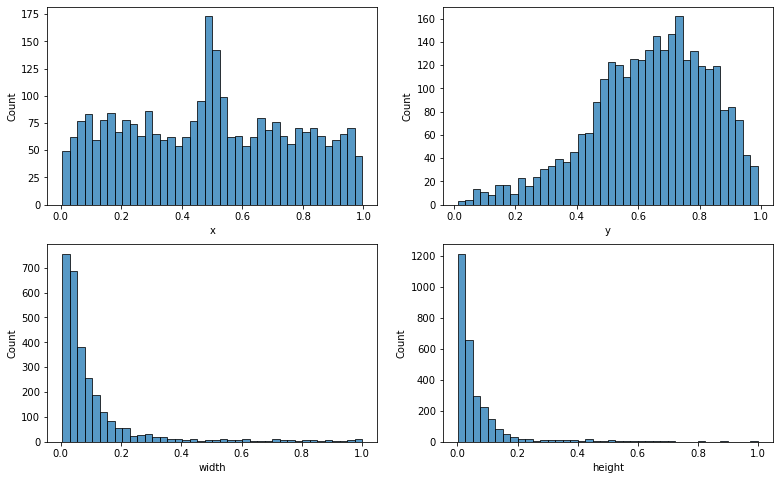

In [5]:
plt.figure(figsize=(13,8))
bins=40

plt.subplot(2,2,1)
sns.histplot(data=df, x='x', bins=bins)

plt.subplot(2,2,2)
sns.histplot(data=df, x='y', bins=bins)

plt.subplot(2,2,3)
sns.histplot(data=df, x='width', bins=bins)

plt.subplot(2,2,4)
sns.histplot(data=df, x='height', bins=bins)

They make sense for number plate images



*   x values are well distributed, which means the cameraman did a good job :D
*   y values are well distributed as well, but, most of the objects are on top of our images.
*   both height and width make sense, because our object is licence plate and they all have almost similiar sizes.







## x vs y | height vs width

<AxesSubplot:xlabel='width', ylabel='height'>

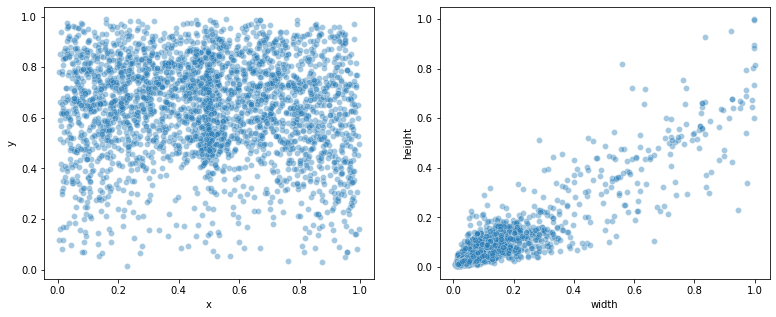

In [4]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.scatterplot(data=df, x='x', y='y', alpha=.4)

plt.subplot(1,2,2)
sns.scatterplot(data=df, x='width', y='height', alpha=.4)


1.   As mentioned above, there is a lack in our dataset in buttom-half part of xy plane.
2.   As we can see, the center of our x axis is dense, it's beacuse humans put the object in the center of the camera.



# Darknet Setup for Google Colab

In [ ]:
# clone repo
#!git clone https://github.com/AlexeyAB/darknet
!git clone https://github.com/amirafshari/LPD-YOLOv4

## GPU

In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

In [ ]:
# make darknet
!make

## Weights

In [ ]:
# pre-trained weights on MS COCO dataset
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

In [ ]:
# pre-trained weights for the convolutional layers
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

### License Plate Weights

In [ ]:
!wget https://drive.google.com/file/d/1eM_y6o50AHGecJUgceyI8aG4qXYaE73I/view?usp=sharing

## Generate train.txt and test.txt
* These files are not in the official repo, but you can find them in my repository.

In [ ]:
!python generate_train.py
!python generate_test.py

## Configs
Wee need to change/create these files: (I configured them for our object, and put them in this repository)


*   data/obj.names
*   data/obj.data
*   cfg/yolov4-custom.cgf
*   cfg/yolov4-obj.cfg


# Training

## Configurations
https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects  


*   1 Epoch = images_in_train_txt / batch = 2000 / 32 = 62.5



## Train

In [ ]:
# Access Denied Error
!chmod +x ./darknet

In [ ]:
# set custom cfg to train mode 
%cd cfg
!sed -i 's/batch=1/batch=64/' yolov4-obj.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' yolov4-obj.cfg
%cd ..

In [ ]:
!./darknet detector train ./data/obj.data ./cfg/yolov4-obj.cfg yolov4.conv.137 -dont_show -map

## Restart
I intrupted the training, we can restart training from our last weight.  
(every 100 iterations our weights are saved to backup folder in yolov4-obj_last.weights) (~every 30 minutes)  
(every 1000 iterations our weight are saved to backup folder in yolo-obj_xxxx.weights)

In [ ]:
!./darknet detector train ./data/obj.data ./cfg/yolov4-obj.cfg ./backup/yolov4-obj_last.weights -dont_show -map

# Sanity Check

#### Setup

In [ ]:
# set custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-obj.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-obj.cfg
%cd ..

In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

#### Sanity Check on COCO

In [ ]:
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg

In [ ]:
imShow('./predictions.jpg')

#### Run on unseen data
I used the kaggle dataset for this.

In [ ]:
!./darknet detector test ./data/obj.data ./cfg/yolov4-obj.cfg ./backup/yolov4-obj_last.weights ../Cars354.png -thresh 0.3

In [ ]:
imShow('./predictions.jpg')

**To process a list of images data/train.txt and save results of detection to result.json file use**


In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg backup/yolov4-obj_last.weights -ext_output -dont_show -out result.json < data/test.txt

# Metrics
**Use -map flag while training for charts**  
mAP-chart (red-line) and Loss-chart (blue-line) will be saved in root directory.  
mAP will be calculated for each 4 Epochs ~ 240 batches

In [ ]:
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg backup/custom.weights

*   Precision: 91 %
*   Average Precision: 89.80 %
*   Recall: 86 %
*   F1-score: 88 %
*   Average IoU: 74.06 %
*   mAP@0.5: 89.80 %
*   Confusion Matrix:
    *   TP = 439
    *   FP = 45
    *   FN = 73
    *   unique_truth_count (TP+FN) = 512
    *   detections_count = 805
